# Comparing existing and new links

Dominika Tkaczyk

7.11.2018

In this analysis I examine how the links existing in the live system compare to the links currently returned by STQ and SBM(V) algorithms.

For the comparison of the algorithms on automatically generated reference strings, see [this notebook](https://github.com/CrossRef/reference-matching-evaluation/blob/master/analyses/comparison.ipynb).

## TL;DR

  * The dataset used in this analysis is composed of 1000 random reference strings from the live system. For each string I have:
    * original link (currently in the system)
    * STQ link (the link returned by STQ form)
    * SBM link (the link returned by SBM algorithm)
    * SBMV link (the link returned by SBMV algorithm)
  * Both variations of SBM are outperformed by STQ (F1 95.3% vs. 90.0% and 86.0%).
  * **SBMV slightly outperforms STQ** (F1 95.7% vs. 95.3%), with precision worse by 0.41 percentage points and recall better by 2.05 percentage points. However, **the differences in precision and recall between SBMV and STQ are not statistically significant**. In other words, the values are so close that we cannot rule out that the differences are due to the randomness in sampling.
  * The highest level of agreement between the links is obtained for the thresholds:
    * simple threshold 67 (for SBM): in 83.0% of the cases SBM link is equal to either original or new STQ link
    * normalized threshold 0.46 (for SBM): in 85.6% of the cases SBM link is equal to either original or new STQ link
    * validation threshold 0.45 (for SBMV): **in 93.9% of the cases SBMV link is equal to either original or new STQ link**
  * The thresholds resulting in the best F1 are very similar to the thresholds resulting in the best agreement (simple threshold: 64 vs. 67, normalized threshold 0.4 vs. 0.46, validation threshold 0.4 vs. 0.45)

## Methodology

The goal of this analysis is to examine the agreement between the approaches, as well as to estimate precision, recall and F1 on the real data.

The following procedure was used to gather the data for these experiments:
1. A random sample of 5000 items was extracted from the system.
2. I iterated over all references in the sampled items, and extracted all 6289 unstructured references (reference strings).
3. I sampled 1000 unstructured references from them, recorded the existing target DOI (if any), and ran STQ, SBM and SBMV algorithms on them.

To estimate precision, recall and F1, I also needed the ground truth (true) target DOI for each reference strings. These were assigned in the following way:
* if DOIs returned by STQ and SBM are the same, I assume it is correct and assign it to the document as the ground truth DOI
* if DOIs returned by STQ and SBM are different, both were inspected manually:
  * if one of them was correct, it was assigned to the document as the ground truth DOI
  * if none of them was correct, I assume no target DOI exists
* if only SBM returned the DOI, it was manually verified:
  * if correct, it was assigned to the document as the ground truth DOI
  * if incorrect, I assume no target DOI exists
  
Note that this ground truth information might not be 100% correct, since not all cases were manually verified.

## Results

In [1]:
import sys
sys.path.append('..')

%matplotlib inline

import json
import matplotlib.pyplot as plt
import numpy as np
import re
import utils.data_format_keys as dfk

from dataset.dataset_utils import get_target_gt_doi, get_target_test_doi
from evaluation.evaluation_utils import doi_test_same, doi_equals
from evaluation.link_metrics import LinkMetricsResults
from evaluation.reference_metrics import ReferenceMetricsResults
from scipy.stats import chi2_contingency
from utils.utils import read_json

DATA_DIR = '../data/existing_links/'

### Precision, recall, F1

First, let's compare precision, recall and F1 of different algorithms.

Here are the results of STQ:

In [2]:
def print_summary(dataset, name):
    link_results = LinkMetricsResults(dataset)
    print('{} precision: {:.4f} (CI at 95% {:.4f}-{:.4f})'
          .format(name, link_results.get(dfk.EVAL_PREC),
                  link_results.get(dfk.EVAL_CI_PREC)[0], link_results.get(dfk.EVAL_CI_PREC)[1]))
    print('{} recall: {:.4f} (CI at 95% {:.4f}-{:.4f})'
          .format(name, link_results.get(dfk.EVAL_REC),
                  link_results.get(dfk.EVAL_CI_REC)[0], link_results.get(dfk.EVAL_CI_REC)[1]))
    print('{} F1: {:.4f}'.format(name, link_results.get(dfk.EVAL_F1)))

dataset_stq = read_json(DATA_DIR + 'sample_1000_stq.json')[dfk.DATASET_DATASET]
print_summary(dataset_stq, 'STQ')

STQ precision: 0.9897 (CI at 95% 0.9820-0.9973)
STQ recall: 0.9191 (CI at 95% 0.8993-0.9389)
STQ F1: 0.9531


For precision and recall the confidence intervals at the confidence level of 95% are given. The confidence interval is the range of values where the real value is likely to be. For example, based on this, we are 95% sure that the real recall of STQ is in the range 0.8993-0.9389. More information about the foundations of sampling and confidence intervals can be found in [this notebook](https://github.com/CrossRef/reference-matching-evaluation/blob/master/analyses/sampling_notes.ipynb).

In order to calculate the results for SBM and SBMV, we have to modify the SBM and SBMV datasets according to the best thresholds calculated previously. These functions will modify the dataset according to the simple, normalized or validation threshold:

In [3]:
def modify_simple_threshold(dataset, threshold):
    for item in dataset:
        if item[dfk.DATASET_SCORE] is not None and item[dfk.DATASET_SCORE] < threshold:
            item[dfk.DATASET_TARGET_TEST][dfk.CR_ITEM_DOI] = None
    return dataset

def modify_norm_threshold(dataset, threshold):
    for item in dataset:
        if item[dfk.DATASET_SCORE] is not None \
            and item[dfk.DATASET_SCORE]/len(item[dfk.DATASET_REF_STRING]) < threshold:
            item[dfk.DATASET_TARGET_TEST][dfk.CR_ITEM_DOI] = None
    return dataset

def modify_valid_threshold(dataset, threshold):
    for item in dataset:
        if item[dfk.DATASET_SCORE] is not None and item[dfk.DATASET_SCORE] < threshold:
            item[dfk.DATASET_TARGET_TEST][dfk.CR_ITEM_DOI] = None
    return dataset

Let's see the results of SBM with a simple threshold of 64:

In [4]:
dataset_sbm_simple = read_json(DATA_DIR + 'sample_1000_sbm.json')[dfk.DATASET_DATASET]
modify_simple_threshold(dataset_sbm_simple, 64)
print_summary(dataset_sbm_simple, 'SBM')

SBM precision: 0.8935 (CI at 95% 0.8702-0.9167)
SBM recall: 0.8285 (CI at 95% 0.8012-0.8559)
SBM F1: 0.8598


Now the results of SBM with the normalized threshold of 0.4:

In [5]:
dataset_sbm_norm = read_json(DATA_DIR + 'sample_1000_sbm.json')[dfk.DATASET_DATASET]
modify_norm_threshold(dataset_sbm_norm, 0.4)
print_summary(dataset_sbm_norm, 'SBM')

SBM precision: 0.8657 (CI at 95% 0.8419-0.8894)
SBM recall: 0.9369 (CI at 95% 0.9192-0.9545)
SBM F1: 0.8999


And finally, the results of SBMV with the validation threshold of 0.4:

In [6]:
dataset_sbmv = read_json(DATA_DIR + 'sample_1000_sbmv.json')[dfk.DATASET_DATASET]
modify_simple_threshold(dataset_sbmv, 0.4)
print_summary(dataset_sbmv, 'SBM')

SBM precision: 0.9758 (CI at 95% 0.9644-0.9872)
SBM recall: 0.9396 (CI at 95% 0.9224-0.9569)
SBM F1: 0.9574


Let's compare all the results in one plot:

In [7]:
def get_means(dataset):
    results = LinkMetricsResults(dataset)
    return [results.get(m) for m in [dfk.EVAL_PREC, dfk.EVAL_REC, dfk.EVAL_F1]]

def get_ci(dataset):
    results = LinkMetricsResults(dataset)
    ms = [results.get(m) for m in [dfk.EVAL_PREC, dfk.EVAL_REC]]
    return [[a-results.get(m)[0] for m, a in zip([dfk.EVAL_CI_PREC, dfk.EVAL_CI_REC], ms)] + [0],
            [results.get(m)[1]-a for m, a in zip([dfk.EVAL_CI_PREC, dfk.EVAL_CI_REC], ms)] + [0]]

def autolabel(ax, rects):
    plt.rcParams.update({'font.size': 10})
    for rect in rects:
        height = rect.get_height()
        text = '{:.2f}'.format(height)
        text = re.sub('\.00$', '', text)
        ax.text(rect.get_x() + rect.get_width()/2., 1.03*height, text, ha='center', va='bottom')

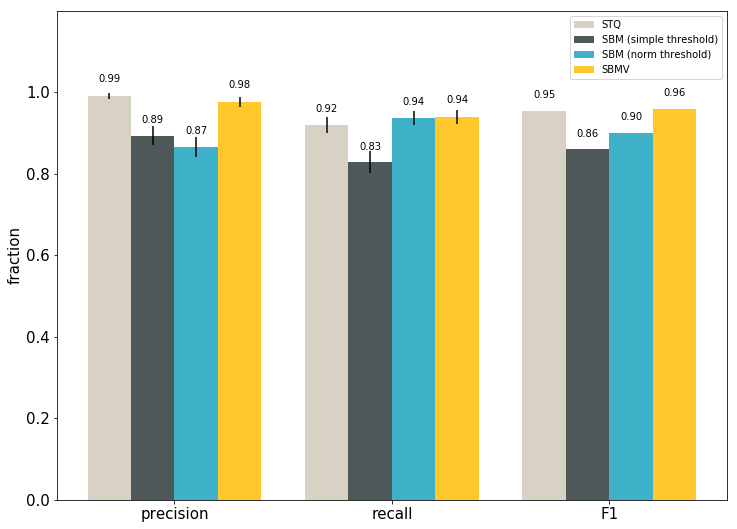

In [8]:
ind = np.arange(3)
width = 0.2
plt.rcParams.update({'font.size': 15, 'legend.fontsize': 10}) 
fig, ax = plt.subplots(figsize=(12, 9))

rects1 = ax.bar(ind - width, get_means(dataset_stq), yerr=get_ci(dataset_stq), width=width, color='#d8d2c4')
rects2 = ax.bar(ind, get_means(dataset_sbm_simple), yerr=get_ci(dataset_sbm_simple), width=width, color='#4f5858')
rects3 = ax.bar(ind + width, get_means(dataset_sbm_norm), yerr=get_ci(dataset_sbm_norm), width=width, color='#3eb1c8')
rects4 = ax.bar(ind + 2*width, get_means(dataset_sbmv), yerr=get_ci(dataset_sbmv), width=width, color='#ffc72c')

ax.set_ylabel('fraction')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('precision', 'recall', 'F1'))
plt.ylim(0, 1.2)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.legend((rects1[0], rects2[0], rects3[0], rects4[0]),
          ('STQ', 'SBM (simple threshold)', 'SBM (norm threshold)', 'SBMV'))
autolabel(ax, rects1)
autolabel(ax, rects2)
autolabel(ax, rects3)
autolabel(ax, rects4)

plt.show() 

As we can see, SBMV outperforms all other algorithms. It is slightly better than STQ (F1 95.74% vs. 95.31%), with precision worse by only 0.41 percentage points and recall better by 2.05 percentage points.

Both variations of SBM are much worse than SBMV and STQ.

Let's also calculate statistical significance between STQ's and SBMV's precision and recall using a Chi-square test of independence:

In [9]:
for metric in [dfk.EVAL_PREC, dfk.EVAL_REC]:
    fun = get_target_test_doi if metric == dfk.EVAL_PREC else get_target_gt_doi
    stq_results = LinkMetricsResults(dataset_stq)
    stq_precision = stq_results.get(metric)
    stq_test_count = len([d for d in dataset_stq if fun(d) is not None])
    stq_precision_success = int(stq_precision * stq_test_count)

    sbmv_results = LinkMetricsResults(dataset_sbmv)
    sbmv_precision = sbmv_results.get(metric)
    sbmv_test_count = len([d for d in dataset_sbmv if fun(d) is not None])
    sbmv_precision_success = int(sbmv_precision * sbmv_test_count)

    _, p, _, _ = chi2_contingency(np.array([[stq_precision_success, stq_test_count-stq_precision_success],
                                           [sbmv_precision_success, sbmv_test_count-sbmv_precision_success]]),
                                  correction=True)
    c = 'this is statistically significant' if p < 0.05 else 'this is not statistically significant'
    print('{} p-value: {:.4f} ({})'.format(metric, p, c))

precision p-value: 0.0777 (this is not statistically significant)
recall p-value: 0.1525 (this is not statistically significant)


For both precision and recall, the differences are not statistically significant. In other words, the values are so close that we cannot rule out that the differences are due to the randomness in sampling.

Finally, let's see what would the validation threshold of SBMV be if we wanted to match STQ's precision:

In [10]:
dataset_sbmv = read_json(DATA_DIR + 'sample_1000_sbmv.json')[dfk.DATASET_DATASET]
results = [LinkMetricsResults(modify_simple_threshold(dataset_sbmv, t)) for t in np.arange(0, 1, 0.01)]
thresholds = np.arange(0, 1, 0.1)
precisions = [r.get(dfk.EVAL_PREC) for r in results]
recalls = [r.get(dfk.EVAL_REC) for r in results]
for i, p in enumerate(precisions):
    if p >= 0.9897:
        break
print('STQ\'s precision is matched for threshold {}'.format(i/100))
print('Recall for this threshold: {}'.format(recalls[i]))

STQ's precision is matched for threshold 0.61
Recall for this threshold: 0.8436213991769548


Unfortunately, by the time we match STQ's precision, the recall drops to 84%, which is much lower than STQ's recall of 92%.

### Agreement between links

Let's also see how the relevance thresholds affect the agreement between the links.

Function *get_category* classifies an item from the dataset into one of the categories:
  * SBM(V) = STQ = orig (all links agree)
  * SBM(V) = STQ =/= orig (original link is different)
  * SBM(V) = orig =/= STQ (new STQ link is different)
  * SBM(V) =/= STQ = orig (SBM(V) link is different)
  * other

In [11]:
def get_category(item_orig, item_stq, item_new):
    if doi_test_same(item_orig, get_target_test_doi(item_stq)) and \
            doi_test_same(item_orig, get_target_test_doi(item_new)):
        return 'SBM(V) = STQ = orig'
    if doi_equals(item_orig) and doi_equals(item_stq) and doi_equals(item_new):
        return 'SBM(V) = STQ = orig'
    if doi_test_same(item_new, get_target_test_doi(item_stq)) and \
            not doi_test_same(item_new, get_target_test_doi(item_orig)):
        return 'SBM(V) = STQ =/= orig'
    if not doi_equals(item_orig) and doi_equals(item_stq) and doi_equals(item_new):
        return 'SBM(V) = STQ =/= orig'
    if doi_test_same(item_new, get_target_test_doi(item_orig)) and \
            not doi_test_same(item_new, get_target_test_doi(item_stq)):
        return 'SBM(V) = orig =/= STQ'
    if doi_equals(item_orig) and not doi_equals(item_stq) and doi_equals(item_new):
        return 'SBM(V) = orig =/= STQ'
    if doi_test_same(item_stq, get_target_test_doi(item_orig)) and \
            not doi_test_same(item_new, get_target_test_doi(item_stq)):
        return 'SBM(V) =/= STQ = orig'
    if doi_equals(item_orig) and doi_equals(item_stq) and not doi_equals(item_new):
        return 'SBM(V) =/= STQ = orig'
    return 'other'

What is the distribution of the categories in the dataset as we vary the simple threshold of SBM?

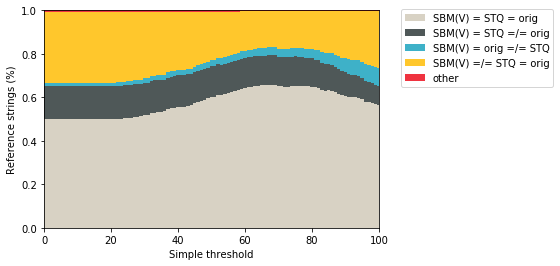

In [12]:
def plot_agreement(categories, data, index, xlab, w):
    p1 = plt.bar(index, data[0], width=w, color='#d8d2c4')
    p2 = plt.bar(index, data[1], width=w, bottom=data[0], color='#4f5858')
    p3 = plt.bar(index, data[2], width=w, bottom=[c1+c2 for c1, c2 in zip(data[0], data[1])], color='#3eb1c8')
    p4 = plt.bar(index, data[3], width=w, bottom=[c1+c2+c3 for c1, c2, c3 in zip(data[0], data[1], data[2])],
                 color='#ffc72c')
    p5 = plt.bar(index, data[4], width=w,
                 bottom=[c1+c2+c3+c4 for c1, c2, c3, c4 in zip(data[0], data[1], data[2], data[3])], color='#ef3340')
    plt.xlim(index[0], index[len(index)-1])
    plt.ylim(0, 1)
    plt.xlabel(xlab)
    plt.ylabel('Reference strings (%)')
    plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), categories, bbox_to_anchor=(1.05, 1.03))
    plt.show()
    
dataset_orig = read_json(DATA_DIR + 'sample_1000_orig.json')[dfk.DATASET_DATASET]
dataset_stq = read_json(DATA_DIR + 'sample_1000_stq.json')[dfk.DATASET_DATASET]
dataset_sbm = read_json(DATA_DIR + 'sample_1000_sbm.json')[dfk.DATASET_DATASET]

data_categories = [[get_category(d1, d2, d3)
                    for d1, d2, d3 in zip(dataset_orig, dataset_stq, modify_simple_threshold(dataset_sbm, t))]
                   for t in np.arange(0, 101, 1)]
categories = ['SBM(V) = STQ = orig', 'SBM(V) = STQ =/= orig', 'SBM(V) = orig =/= STQ', 'SBM(V) =/= STQ = orig', 'other']
categories_counts = [[d.count(cat)/1000 for d in data_categories] for cat in categories]
plot_agreement(categories, categories_counts, np.arange(0, 101, 1), 'Simple threshold', 1)

Let's also calculate the simple threshold, for which the best agreement is achieved:

In [13]:
best_agreement = max(categories_counts[0])
index = categories_counts[0].index(best_agreement)
print('The best agreement between original, STQ, and SBM with a simple threshold')
print('Threshold: {}'.format(index))
print('All links agree in {:.1f}% of cases'.format(100*best_agreement))
print('SBM link agrees with either original or STQ link in {:.1f}% of cases'
      .format(100*(categories_counts[0][index] + categories_counts[1][index] + categories_counts[2][index])))

The best agreement between original, STQ, and SBM with a simple threshold
Threshold: 67
All links agree in 65.9% of cases
SBM link agrees with either original or STQ link in 83.0% of cases


What happens with the categories in the dataset as we vary the normalized threshold of SBM?

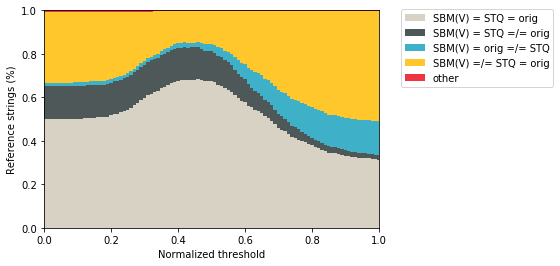

In [14]:
dataset_orig = read_json(DATA_DIR + 'sample_1000_orig.json')[dfk.DATASET_DATASET]
dataset_stq = read_json(DATA_DIR + 'sample_1000_stq.json')[dfk.DATASET_DATASET]
dataset_sbm = read_json(DATA_DIR + 'sample_1000_sbm.json')[dfk.DATASET_DATASET]

data_categories = [[get_category(d1, d2, d3)
                    for d1, d2, d3 in zip(dataset_orig, dataset_stq, modify_norm_threshold(dataset_sbm, t))]
                   for t in np.arange(0, 1.01, 0.01)]
categories_counts = [[d.count(cat)/1000 for d in data_categories] for cat in categories]
plot_agreement(categories, categories_counts, np.arange(0, 1.01, 0.01), 'Normalized threshold', 0.01)

And the normalized threshold, for which we have the best agreement:

In [15]:
best_agreement = max(categories_counts[0])
index = categories_counts[0].index(best_agreement)
print('The best agreement between original, STQ, and SBM with a normalized threshold')
print('Threshold: {}'.format(index/100))
print('All links agree in {:.1f}% of cases'.format(100*best_agreement))
print('SBM link agrees with either original or STQ link in {:.1f}% of cases'
      .format(100*(categories_counts[0][index] + categories_counts[1][index] + categories_counts[2][index])))

The best agreement between original, STQ, and SBM with a normalized threshold
Threshold: 0.46
All links agree in 68.5% of cases
SBM link agrees with either original or STQ link in 85.6% of cases


Finally, what happens with the categories in the dataset as we vary the validation threshold of SBMV?

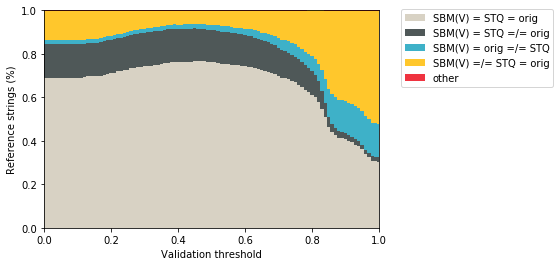

In [16]:
dataset_orig = read_json(DATA_DIR + 'sample_1000_orig.json')[dfk.DATASET_DATASET]
dataset_stq = read_json(DATA_DIR + 'sample_1000_stq.json')[dfk.DATASET_DATASET]
dataset_sbmv = read_json(DATA_DIR + 'sample_1000_sbmv.json')[dfk.DATASET_DATASET]

data_categories = [[get_category(d1, d2, d3)
                    for d1, d2, d3 in zip(dataset_orig, dataset_stq, modify_simple_threshold(dataset_sbmv, t))]
                   for t in np.arange(0, 1.01, 0.01)]
categories_counts = [[d.count(cat)/1000 for d in data_categories] for cat in categories]
plot_agreement(categories, categories_counts, np.arange(0, 1.01, 0.01), 'Validation threshold', 0.01)

And finally the validation threshold, for which we have the best agreement:

In [17]:
best_agreement = max(categories_counts[0])
index = categories_counts[0].index(best_agreement)
print('The best agreement between original, STQ, and SBMV with a validation threshold')
print('Threshold: {}'.format(index/100))
print('All links agree in {:.1f}% of cases'.format(100*best_agreement))
print('SBMV link agrees with either original or STQ link in {:.1f}% of cases'
      .format(100*(categories_counts[0][index] + categories_counts[1][index] + categories_counts[2][index])))

The best agreement between original, STQ, and SBMV with a validation threshold
Threshold: 0.45
All links agree in 76.7% of cases
SBMV link agrees with either original or STQ link in 93.9% of cases


From these results we see that there is a large agreement between the links. SBMV has the best agreement with other links for the validation threshold of 0.45: in 76.7% of the cases all links agree, and in 93.9% of the cases SBMV link agrees with either original or STQ link.

The lines also look fairly flat in the neighbourhood of the best threshold 0.45. This means we have quite a large range of thresholds, for which the agreement is very high, including the threshold best by F1 (0.4).

### The analysis of the differences

Let's also look more closely at the reasons for differences between the links. SBM links analysed in this section are links without any threshold.

In [18]:
data = read_json(DATA_DIR + 'sample_1000_reasons.json')
orig_link = 'original_link'
stq_link = 'current_STQ_link'
sbm_link = 'search_API_link'

#### Null original link

The first category we will explore are references currently not matched to any target document in the system. How many references don't have the original link?

In [19]:
data_orig_null = [d for d in data if d[orig_link] is None]
print('Null original link: {}'.format(len(data_orig_null)))

Null original link: 458


45.8% of reference strings in our sample are not linked to anything. In how many cases we have a new STQ link?

In [20]:
data_orig_null_stq_exists = [d for d in data_orig_null if d[stq_link] is not None]
print('Null original link, STQ link exists: {}'.format(len(data_orig_null_stq_exists)))

Null original link, STQ link exists: 146


In 32% of references with null original link we have the new STQ link. And how many of those have the same SBM link?

In [21]:
data_orig_null_sbm_stq_equal = [d for d in data_orig_null if d[stq_link] is not None and d[stq_link] == d[sbm_link]]
print('Null original link; STQ and SBM agree: {}'.format(len(data_orig_null_sbm_stq_equal)))

Null original link; STQ and SBM agree: 139


It seems there is a high agreement between STQ and SBM, almost all new STQ links were "confirmed" by SBM.

We are left with 319 cases, in which the original link is null and STQ and SBM links differ. I manually inspected them and provided an explanation of what happened. This function will show the distribution of those explanations ("comments"):

In [22]:
def summarize_comments(data):
    comments = [d['reason'] for d in data]
    comments = list(set([(r, comments.count(r)) for r in comments]))
    comments.sort(key=lambda x: x[1], reverse=True) 
    return comments 

The distribution of the explanations of the cases where original link is null and SBM and STQ links disagree:

In [23]:
data_orig_null_sbm_stq_disagree = [d for d in data_orig_null if d[stq_link] != d[sbm_link]]
summarize_comments(data_orig_null_sbm_stq_disagree)

[('original link null; STQ link null; SBM link incorrect', 259),
 ('original link null; STQ link null; SBM link correct', 49),
 ('original link null; STQ link null; SBM links to a review', 3),
 ('original link null; STQ and SBM disagree; same landing page', 2),
 ('original link null; STQ and SBM disagree; both incorrect', 1),
 ('original link null; STQ and SBM disagree; SBM link incorrect', 1),
 ('original link null; STQ and SBM disagree, both correct', 1),
 ('original link null; STQ link null; SBM links to a chapter', 1),
 ('original link null; STQ and SBM disagree; same metadata', 1),
 ('original link null; STQ and SBM disagree; SBM links to a chapter', 1)]

We have the following cases:
  * 263: only SBM link present and incorrect 
  * 49: only SBM present and correct
  * 3: STQ and SBM links disagree, but the either the landing pages or the document metadata are the same
  * 4: other cases

Of course high fraction of incorrect links is affected by not applying any threshold.

#### All links agree

How many cases we have, in which all three links agree?

In [24]:
data_all_agree = [d for d in data
                  if d[orig_link] is not None and d[orig_link] == d[stq_link] and d[sbm_link] == d[stq_link]]
print('All links agree: {}'.format(len(data_all_agree)))

All links agree: 481


Almost half of all the cases, and 89% of the cases with not null original link. This also confirms high agreement between STQ and SBM.

#### Original link is different

In how many cases SBM link is the same as STQ link, but original link is not null and different?

In [25]:
data_diff_orig = [d for d in data
                  if d[orig_link] is not None and d[orig_link] != d[stq_link] and d[sbm_link] == d[stq_link]]
print('Original link is different : {}'.format(len(data_diff_orig)))
summarize_comments(data_diff_orig)

Original link is different : 2


[('original link incorrect', 1), ('different version of the paper', 1)]

Only 2 references:
  * in one case the DOIs link to two different versions of the same paper
  * in the second case the original link is incorrect
  
#### STQ link is different
  
Now let's see the cases, where original and SBM links agree and STQ is different:

In [26]:
data_diff_stq = [d for d in data
                 if d[orig_link] is not None and d[orig_link] != d[stq_link] and d[sbm_link] == d[orig_link]]
print('STQ link is different : {}'.format(len(data_diff_stq)))
summarize_comments(data_diff_stq)

STQ link is different : 32


[('STQ link missing', 32)]

In all cases STQ link is simply missing.

#### SBM link is different

How many cases we have, where SBM link is different from the other two?

In [27]:
data_diff_sbt = [d for d in data
                if d[orig_link] is not None and d[orig_link] == d[stq_link] and d[sbm_link] != d[orig_link]]
print('SBT link is different : {}'.format(len(data_diff_sbt)))
summarize_comments(data_diff_sbt)

SBT link is different : 24


[('SBM link incorrect', 13),
 ('same document (metadata)', 3),
 ('same document (landing page)', 2),
 ('SBM links to a chapter', 2),
 ('original link incorrect', 1),
 ('SBM links to a correction', 1),
 ('original link incorrect; STQ link incorrect; SBM link correct', 1),
 ('SBM links to one paper in conference proceedings', 1)]

Out of 24 cases:
  * in 13 cases SBM link is incorrect (11 of those are strings not containing the title of the reference)
  * in 5 the linked documents appear to be the same
  * in 4 cases SBM links to a document related to the correct one, such as a chapter or a correction
  * in 2 case the original link is incorrect or incorrectly null

#### All three links are different

In [28]:
data_diff_all = [d for d in data
                 if d[orig_link] is not None and d[orig_link] != d[stq_link]
                 and d[sbm_link] != d[orig_link] and d[stq_link] != d[sbm_link]]
print('All links different : {}'.format(len(data_diff_all)))
summarize_comments(data_diff_all)

All links different : 3


[('STQ link missing; both link to a different chapter', 2),
 ('STQ link missing; SBM link incorrect', 1)]

In all three cases STQ link is missing and SBM link is incorrect.